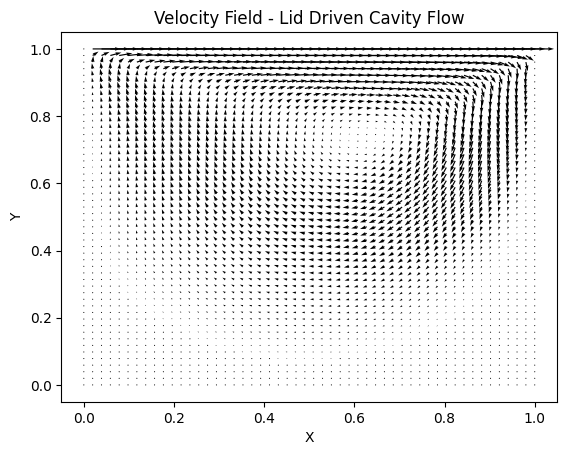

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Lx = 1.0  # Length of the cavity in x-direction
Ly = 1.0  # Length of the cavity in y-direction
Nx = 50  # Number of cells in x-direction
Ny = 50  # Number of cells in y-direction
Re = 100  # Reynolds number
U_wall = 1.0  # Lid velocity

dx = Lx / Nx
dy = Ly / Ny
dt = 0.001  # Time step
rho = 1.0  # Density
nu = 1.0 / Re  # Kinematic viscosity
tol = 1e-6  # Convergence tolerance
max_iter = 5000  # Maximum iterations

# Initialize fields
u = np.zeros((Nx + 2, Ny + 2))  # Velocity in x-direction
v = np.zeros((Nx + 2, Ny + 2))  # Velocity in y-direction
p = np.zeros((Nx + 2, Ny + 2))  # Pressure
b = np.zeros((Nx + 2, Ny + 2))  # RHS of pressure Poisson equation

# Boundary conditions
u[:, -1] = U_wall  # Lid-driven top wall
u[:, 0] = 0  # Bottom wall
v[:, 0] = 0  # Bottom wall
v[:, -1] = 0  # Top wall


def build_up_b(b, u, v, rho, dt, dx, dy):
    b[1:-1, 1:-1] = (
        rho * (1 / dt * ((u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dx) +
                         (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dy))
               - ((u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dx)) ** 2
               - 2 * ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dy) *
                      (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dx))
               - ((v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dy)) ** 2)
    )


def pressure_poisson(p, b, dx, dy):
    pn = np.empty_like(p)
    for _ in range(50):  # Inner iterations for Poisson solver
        pn[:] = p[:]
        p[1:-1, 1:-1] = (
            (dy**2 * (pn[2:, 1:-1] + pn[:-2, 1:-1]) +
             dx**2 * (pn[1:-1, 2:] + pn[1:-1, :-2]) -
             b[1:-1, 1:-1] * dx**2 * dy**2) /
            (2 * (dx**2 + dy**2))
        )
        # Boundary conditions for pressure
        p[:, 0] = p[:, 1]  # dp/dy = 0 at bottom
        p[:, -1] = p[:, -2]  # dp/dy = 0 at top
        p[0, :] = p[1, :]  # dp/dx = 0 at left
        p[-1, :] = p[-2, :]  # dp/dx = 0 at right


def velocity_update(u, v, p, rho, nu, dt, dx, dy):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    un[:] = u[:]
    vn[:] = v[:]

    # Update u velocity
    u[1:-1, 1:-1] = (
        un[1:-1, 1:-1] -
        un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[:-2, 1:-1]) -
        vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[1:-1, :-2]) -
        dt / (2 * rho * dx) * (p[2:, 1:-1] - p[:-2, 1:-1]) +
        nu * (dt / dx**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) +
              dt / dy**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]))
    )

    # Update v velocity
    v[1:-1, 1:-1] = (
        vn[1:-1, 1:-1] -
        un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) -
        vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[1:-1, :-2]) -
        dt / (2 * rho * dy) * (p[1:-1, 2:] - p[1:-1, :-2]) +
        nu * (dt / dx**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) +
              dt / dy**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]))
    )

    # Boundary conditions for velocity
    u[:, 0] = 0
    u[:, -1] = U_wall
    v[:, 0] = 0
    v[:, -1] = 0
    u[0, :] = 0
    u[-1, :] = 0
    v[0, :] = 0
    v[-1, :] = 0


# Main loop
for n in range(max_iter):
    un = np.copy(u)
    vn = np.copy(v)

    build_up_b(b, u, v, rho, dt, dx, dy)
    pressure_poisson(p, b, dx, dy)
    velocity_update(u, v, p, rho, nu, dt, dx, dy)

    # Check convergence
    norm = np.linalg.norm(u - un) + np.linalg.norm(v - vn)
    if norm < tol:
        print(f"Converged in {n} iterations.")
        break

# Visualization
X, Y = np.meshgrid(np.linspace(0, Lx, Nx + 2), np.linspace(0, Ly, Ny + 2))
plt.quiver(X, Y, u.T, v.T)
plt.title("Velocity Field - Lid Driven Cavity Flow")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


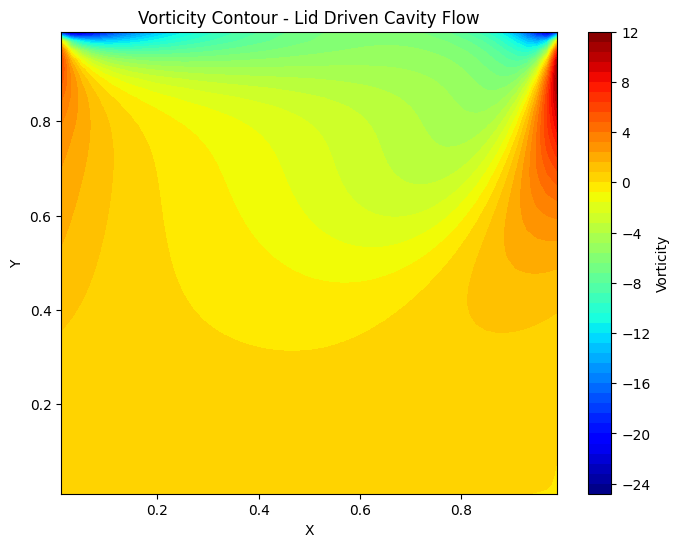

In [ ]:
# Calculate vorticity
def compute_vorticity(u, v, dx, dy):
    """
    Computes the vorticity field from velocity components u and v.
    """
    vorticity = (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dx) - (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dy)
    return vorticity

# Compute the vorticity
vorticity = compute_vorticity(u, v, dx, dy)

# Visualization
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(np.linspace(dx/2, Lx-dx/2, Nx), np.linspace(dy/2, Ly-dy/2, Ny))
plt.contourf(X, Y, vorticity.T, levels=50, cmap='jet')
plt.colorbar(label='Vorticity')
plt.title('Vorticity Contour - Lid Driven Cavity Flow')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


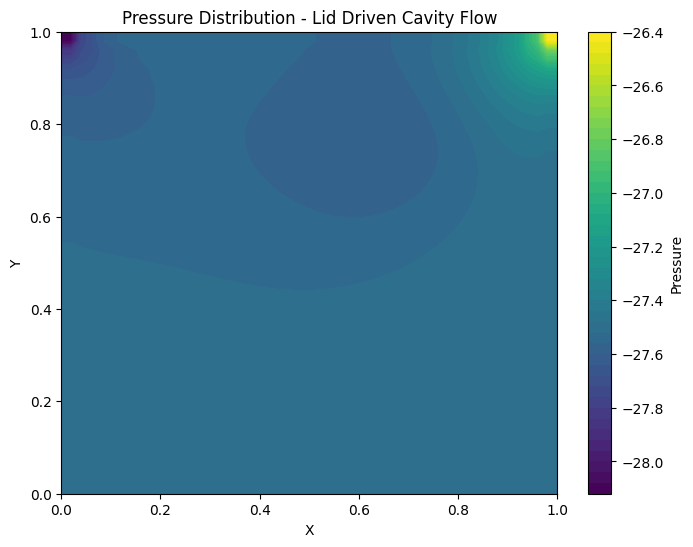

In [ ]:
# Visualization of Pressure Distribution
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(np.linspace(0, Lx, Nx + 2), np.linspace(0, Ly, Ny + 2))
plt.contourf(X, Y, p.T, levels=50, cmap='viridis')
plt.colorbar(label='Pressure')
plt.title('Pressure Distribution - Lid Driven Cavity Flow')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


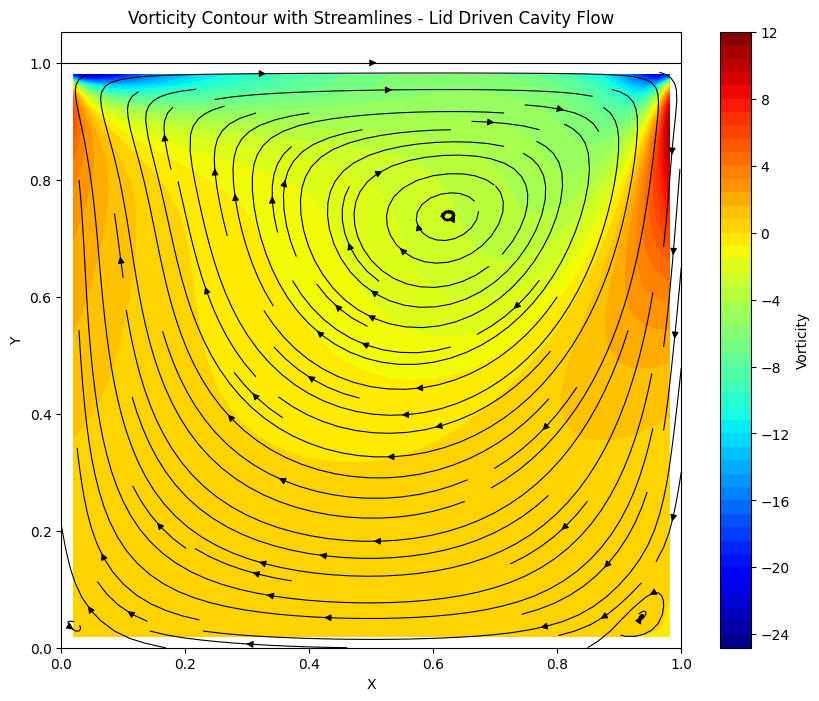

In [ ]:
# Compute vorticity
def compute_vorticity(u, v, dx, dy):
    """
    Computes the vorticity field from velocity components u and v.
    """
    vorticity = (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dx) - (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dy)
    return vorticity

# Calculate vorticity
vorticity = compute_vorticity(u, v, dx, dy)

# Create a grid for velocity field
X, Y = np.meshgrid(np.linspace(0, Lx, Nx + 2), np.linspace(0, Ly, Ny + 2))

# Plot vorticity with streamlines
plt.figure(figsize=(10, 8))
plt.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], vorticity.T, levels=50, cmap='jet')
plt.colorbar(label='Vorticity')

# Add streamlines
plt.streamplot(X, Y, u.T, v.T, color='k', linewidth=0.8, density=1.2)

# Add titles and labels
plt.title('Vorticity Contour with Streamlines - Lid Driven Cavity Flow')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
